# Semi-supervised anomaly detection: log mel-spectrogram - model 1

This notebook will show how to implement in Tensorflow the AE model used as baseline for [DCASE 2020](http://dcase.community/challenge2020/task-unsupervised-detection-of-anomalous-sounds)

## Libraries

Let's load the libraries for this notebook.
- **Tensorflow dataset** to load the dataset
- **Tensorflow** to create an AE model
- **Pandas** to manipulate results
- **Sklearn** to compute metrics
- **Plotnine** to plot results

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

from tensorflow.keras.layers import (
    InputLayer,
    Dense,
    BatchNormalization,
    Activation,
)

from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

import numpy as np
import pandas as pd

import sklearn
from sklearn.metrics import (
    confusion_matrix, 
    classification_report,
    roc_auc_score
)

import plotnine as p9

import datetime

import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
print(f"Tensorflow datasets: {tfds.__version__}")
print(f"Tensorflow: {tf.__version__}")
print(f"Sklearn: {sklearn.__version__}")
print(f"Numpy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Plotnine: {p9.__version__}")

Tensorflow datasets: 4.2.0
Tensorflow: 2.4.1
Sklearn: 0.24.2
Numpy: 1.19.5
Pandas: 1.2.4
Plotnine: 0.8.0


Let's set the seed for the Tensorflow dataset.

In [3]:
config = tfds.ReadConfig(try_autocache=True, shuffle_seed=42)

## Dataset

Let's load the dataset and create three sets (train, validation, test). We make the train set (90%) and validation set (10%) from the train data and the test set from the test data. 

In [4]:
import pump
data_dir = "../dataset"

(train, val, test), info = tfds.load(
    "pump",
    split=["train[:90%]", "train[90%:]", "test"],
    data_dir=data_dir,
    with_info=True,
    shuffle_files=True,
    read_config=config,
)

## Feature extraction

We will use 128 log mel-band energies from a spectrogram with an analysis frame of 64 ms and 50% hop size. 

In [5]:
A = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins=128, num_spectrogram_bins=512+1, sample_rate=16_000, dtype=tf.float32
)

In [6]:
def mel(item):
    audio = tf.cast(item["audio"], tf.float32)
    audio = audio / 2**15

    # Calculate the STFT of the audio signal
    stfts = tf.signal.stft(
            audio,
            frame_length=1024,
            frame_step=512,
            pad_end=False,  # librosa test compatibility
        )
    # Get Magnitude fo the STFT
    mag_stfts = tf.abs(stfts)

    # Get the mel-spectrogram
    melgrams = tf.tensordot(
            tf.square(mag_stfts), A, axes=1
    )

    # Change of base for logarithmics: from natural logarithmic to common logarithmic 
    def _tf_log10(x):
        numerator = tf.math.log(x)
        denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
        return numerator / denominator

    # Calculate the log-mel spectrogram    
    log_melgrams = 20 / 2 * _tf_log10(melgrams + 10e-6)

    # Concat 5 time frames together to feed the model
    concat_melgrams = tf.concat(
        [
            tf.roll(log_melgrams, shift=1, axis=0),
            tf.roll(log_melgrams, shift=2, axis=0),
            log_melgrams,
            tf.roll(log_melgrams, shift=-1, axis=0),
            tf.roll(log_melgrams, shift=-2, axis=0)
        ],
        axis=1,
    )
    concat_melgrams = concat_melgrams[2:-2,:]

    item["audio"] = concat_melgrams
    return item

Let's prepare the sets for training. AE models need that the input and the output be the same.

In [7]:
def prep_train(item):
    return item["audio"], item["audio"]

In [8]:
BATCH_SIZE = 512
SHUFFLE_BUFFER_SIZE = 1024

train = train.map(mel)
train2 = train.map(prep_train).batch(BATCH_SIZE)

val = train.map(mel)
val2 = train.map(prep_train).batch(BATCH_SIZE)

test = test.map(mel)
test2 = test.batch(BATCH_SIZE)

## Training

This is the same AE model described used as baseline.

In [9]:
autoencoder = Sequential(
    [
        InputLayer(input_shape=(307, 640)),
        Dense(128),
        BatchNormalization(),
        Activation('relu'),
        Dense(128),
        BatchNormalization(),
        Activation('relu'),
        Dense(128),
        BatchNormalization(),
        Activation('relu'),
        Dense(128),
        BatchNormalization(),
        Activation('relu'),
        Dense(8),
        BatchNormalization(),
        Activation('relu'),
        Dense(128),
        BatchNormalization(),
        Activation('relu'),
        Dense(128),
        BatchNormalization(),
        Activation('relu'),
        Dense(128),
        BatchNormalization(),
        Activation('relu'),
        Dense(128),
        BatchNormalization(),
        Activation('relu'),
        Dense(640)
    ]
)

In [10]:
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 307, 128)          82048     
_________________________________________________________________
batch_normalization (BatchNo (None, 307, 128)          512       
_________________________________________________________________
activation (Activation)      (None, 307, 128)          0         
_________________________________________________________________
dense_1 (Dense)              (None, 307, 128)          16512     
_________________________________________________________________
batch_normalization_1 (Batch (None, 307, 128)          512       
_________________________________________________________________
activation_1 (Activation)    (None, 307, 128)          0         
_________________________________________________________________
dense_2 (Dense)              (None, 307, 128)          1

We use same parameters as the paper.

In [11]:
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())

Let's create a Tensorboard callback to check the results in Tensorboard and a ModelCheckpoint callback to save the best model.

In [12]:
log_dir = os.path.join('..', 'logs', 'semi-mel', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir, update_freq=1, histogram_freq=1, write_graph=True
)

In [13]:
checkpoint_filepath = os.path.join("tmp", "semi-mel", "checkpoint")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [14]:
history = autoencoder.fit(
    train2,
    epochs=100,
    shuffle=True,
    validation_data=val2,
    callbacks=[tb_callback, model_checkpoint_callback],
    verbose=1,
)

Epoch 1/100
6/6 [==============================] - 71s 12s/step - loss: 222.1035 - val_loss: 221.2142
Epoch 2/100
6/6 [==============================] - 68s 12s/step - loss: 213.8695 - val_loss: 214.2472
Epoch 3/100
6/6 [==============================] - 68s 12s/step - loss: 202.8994 - val_loss: 191.2484
Epoch 4/100
6/6 [==============================] - 68s 12s/step - loss: 191.1925 - val_loss: 166.1971
Epoch 5/100
6/6 [==============================] - 67s 12s/step - loss: 179.9613 - val_loss: 139.8357
Epoch 6/100
6/6 [==============================] - 67s 12s/step - loss: 167.8799 - val_loss: 124.0937
Epoch 7/100
6/6 [==============================] - 65s 11s/step - loss: 158.7889 - val_loss: 107.5820
Epoch 8/100
6/6 [==============================] - 66s 11s/step - loss: 148.2392 - val_loss: 95.0089
Epoch 9/100
6/6 [==============================] - 65s 11s/step - loss: 136.8130 - val_loss: 102.2799
Epoch 10/100
6/6 [==============================] - 66s 11s/step - loss: 127.6617 -

## Testing

In [42]:
autoencoder.load_weights(checkpoint_filepath)

In [43]:
VERSION="1"
saved_model_path = autoencoder.save(
    os.path.join("..", "..", "..", "production", "backend", "models", "mel", VERSION),
    save_format="tf",
)

INFO:tensorflow:Assets written to: ..\..\..\production\backend\models\mel\1\assets


INFO:tensorflow:Assets written to: ..\..\..\production\backend\models\mel\1\assets


Let's join train and test set together for faster predictions.

In [44]:
audios = train.concatenate(test)

In [45]:
pred = autoencoder.predict(audios.map(lambda item: item["audio"]).batch(BATCH_SIZE))

Let's compute the reconstruction error for all audios.

In [46]:
error_lst = []
for item, pred in zip(tfds.as_numpy(audios), pred):
    error = np.mean(np.square(item["audio"] - pred))
    error_lst.append(error)

To check how the model behaves, we can tranform the Tensorflow dataset into a dataframe and add the previous computed reconstruction error to it.

In [47]:
audios_df = tfds.as_dataframe(audios, info)

# Convert byte-type texts to string-type texts
for col in audios_df:
    if isinstance(audios_df[col][0], bytes):
        audios_df[col] = audios_df[col].str.decode("utf8")

dct_columns = {
    "audio/id": "id", 
    "audio/machine": "machine_id", 
    "audio/split": "split",
}

# Convert object-type columns to a more convenient data type
dct_types = {
    "id": "string",
    "machine_id": "category",
    "split": "category",
    "label": "category",
}

audios_df = (
    audios_df
    .rename(columns=dct_columns)
    .astype(dct_types)
)

audios_df["split"] = audios_df["split"].cat.rename_categories({0: "train", 1: "test"})
audios_df["label"] = audios_df["label"].cat.rename_categories({0: "normal", 1: "anomaly"})

audios_df.sample(5)

,audio,id,machine_id,split,label
1307,"[[-9.874631, -6.8349433, -2.0404174, -4.321853...",0164,04,train,normal
1663,"[[-12.179075, -7.697941, -2.2378461, -6.618811...",0062,04,train,normal
3847,"[[2.2923799, 1.3340228, -3.297722, -6.108287, ...",0007,04,test,anomaly
2092,"[[-4.48533, -5.019704, -6.227432, -39.863815, ...",0018,04,train,normal
1534,"[[-8.116749, -9.269882, -17.792938, -11.89989,...",0299,00,train,normal


In [48]:
audios_df["error"] = error_lst

In [49]:
audios_df.sample(5)

,audio,id,machine_id,split,label,error
2953,"[[-3.1785088, -2.1869829, 0.71435684, -0.11960...",0496,06,train,normal,32.028820
1076,"[[-2.4113069, -3.2431123, -6.5061135, -8.96151...",0472,00,train,normal,35.711353
2085,"[[-9.033941, -2.5568657, 3.4455492, 3.7080374,...",0263,04,train,normal,51.452026
2523,"[[-12.292691, -12.874882, -14.346399, -7.57007...",0583,04,train,normal,38.696583
1948,"[[-0.7825079, -1.3064833, -2.4592886, -8.19665...",0684,02,train,normal,21.521887


In [50]:
(
    audios_df
    .query("split == 'train'")
    .groupby("machine_id")
    .agg({"error": ["mean", "std"]})
)

error           
                 mean        std
machine_id                      
00          33.149893  15.331841
02          32.553738  14.315009
04          32.871041  14.002614
06          34.219801  15.921031

In [51]:
(
    audios_df
    .query("split == 'test'")
    .groupby(["label", "machine_id"])
    .agg({"error": ["mean", "std"]})
)

error           
                         mean        std
label   machine_id                      
normal  00          37.253017  22.156428
        02          34.656466  15.223976
        04          35.231260  17.636893
        06          36.572568  16.185259
anomaly 00          40.008845  20.102486
        02          38.128644  20.785872
        04          36.555383  17.779424
        06          34.843085  15.920741

It seems this model can't distinguish anomaly sound from normal sounds very well.

Let's plot the a histogram of the construction error per machine to see more clear.

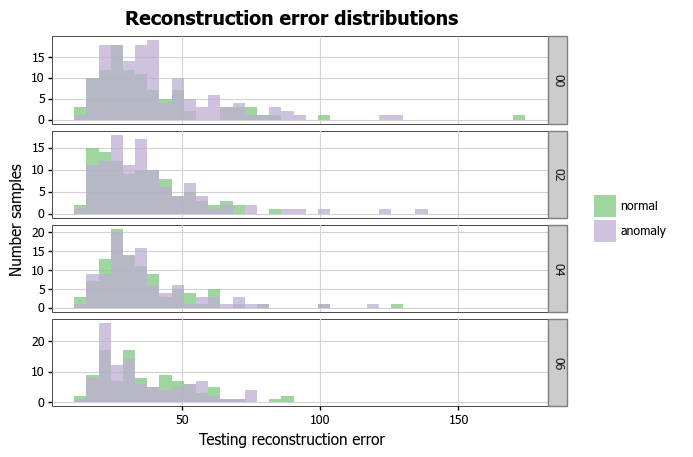

In [52]:
p = (
    p9.ggplot(audios_df.query("split == 'test'"), p9.aes(x="error", fill="label"))
    + p9.geom_histogram(
        p9.aes(y="stat(count)"), position="identity", alpha=0.75
    )
    + p9.scale_x_continuous(name="Testing reconstruction error")
    + p9.scale_y_continuous(name="Number samples")
    + p9.labs(
        title="Reconstruction error distributions",
    )
    + p9.scale_fill_brewer(type="qualitative", palette="Accent") 
    + p9.facet_grid("machine_id ~ .", scales="free")
    + p9.theme_bw()
    + p9.theme(
        panel_border=p9.element_rect(colour="black", fill=None, size=0.5),
        axis_text_x=p9.element_text(colour="black", size=9),
        axis_text_y=p9.element_text(colour="black", size=9),
        legend_key=p9.element_blank(),
        legend_title=p9.element_blank(),
        panel_grid_major=p9.element_line(colour="#d3d3d3"),
        panel_grid_minor=p9.element_blank(),
        panel_background=p9.element_blank(),
        plot_title=p9.element_text(size=14, family="Tahoma", face="bold"),
        text=p9.element_text(family="Tahoma"),
    )
)

print(p)

Histograms show more clear that the model can't differentiate anomaly audios from normal audio very well.

This [AWS](https://aws.amazon.com/es/blogs/machine-learning/performing-anomaly-detection-on-industrial-equipment-using-audio-signals/) post shows how the histogram from a good model should look like.

![Better model](https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2020/12/22/ML-1479-4.jpg)

## Metrics

Let's see how bad our model is. To distinguish anomaly audios from normal audios, we set the threshold one standard deviation above the mean of the train set. 

In [53]:
avg = (
    audios_df
    .query("split == 'train'")
    ["error"]
    .mean()
)

std = (
    audios_df
    .query("split == 'train'")
    ["error"]
    .std()
)

threshold = avg + std

Let's create a new column with the predicted label based on the threshold.

In [54]:
print(threshold)

48.243759038053106


In [55]:
audios_df["label_pred"] = audios_df["error"] > threshold

audios_df = audios_df.astype({"label_pred": "int"})
audios_df.head()

,audio,id,machine_id,split,label,error,label_pred
0,"[[1.5932982, 1.294384, 1.1611198, -24.297667, ...",0784,06,train,normal,19.163870,0
1,"[[-7.030608, -7.263412, -7.1459956, -13.880009...",0215,02,train,normal,26.678539,0
2,"[[-7.4239073, -7.0891733, -5.364052, -14.60322...",0918,06,train,normal,20.216681,0
3,"[[-5.473754, -4.7174063, -2.182263, -6.692034,...",0033,06,train,normal,26.082094,0
4,"[[-32.570705, -10.010296, -3.2296658, -0.16753...",0580,02,train,normal,29.236591,0


Let's show the precision, recall, f1-score and roc-auc score for the four machines.

In [56]:
audios_df["label"] = audios_df["label"].cat.rename_categories({"normal": 0, "anomaly": 1})

### Machine_id=00

In [57]:
machine_id = "00"
temp = (
    audios_df
    .query("machine_id == @machine_id and split == 'test'")
)  
print(classification_report(temp["label"], temp["label_pred"]))

              precision    recall  f1-score   support

           0       0.42      0.79      0.55       100
           1       0.63      0.25      0.36       143

    accuracy                           0.47       243
   macro avg       0.53      0.52      0.46       243
weighted avg       0.55      0.47      0.44       243



In [58]:
print(confusion_matrix(temp["label"], temp["label_pred"]))

[[ 79  21]
 [107  36]]


In [59]:
score = roc_auc_score(temp["label"], temp["label_pred"])
print(f"ROC-AUC score: {score:.4f}")

ROC-AUC score: 0.5209


This model is slightly better distinguishing sounds for this machine that tossing a coin. 

### Machine_id=02

In [60]:
machine_id = "02"
temp = (
    audios_df
    .query("machine_id == @machine_id and split == 'test'")
)  
print(classification_report(temp["label"], temp["label_pred"]))

              precision    recall  f1-score   support

           0       0.48      0.81      0.60       100
           1       0.56      0.22      0.31       111

    accuracy                           0.50       211
   macro avg       0.52      0.51      0.46       211
weighted avg       0.52      0.50      0.45       211



In [61]:
print(confusion_matrix(temp["label"], temp["label_pred"]))

[[81 19]
 [87 24]]


In [62]:
score = roc_auc_score(temp["label"], temp["label_pred"])
print(f"ROC-AUC score: {score:.4f}")

ROC-AUC score: 0.5131


This model is slightly better distinguishing sounds for this machine that tossing a coin. 

### Machine_id=04

In [63]:
machine_id = "04"
temp = (
    audios_df
    .query("machine_id == @machine_id and split == 'test'")
)  
print(classification_report(temp["label"], temp["label_pred"]))

              precision    recall  f1-score   support

           0       0.51      0.83      0.63       100
           1       0.54      0.20      0.29       100

    accuracy                           0.52       200
   macro avg       0.52      0.52      0.46       200
weighted avg       0.52      0.52      0.46       200



In [64]:
print(confusion_matrix(temp["label"], temp["label_pred"]))

[[83 17]
 [80 20]]


In [65]:
score = roc_auc_score(temp["label"], temp["label_pred"])
print(f"ROC-AUC score: {score:.4f}")

ROC-AUC score: 0.5150


This model is slightly better distinguishing sounds for this machine that tossing a coin. 

### Machine_id=06

In [66]:
machine_id = "06"
temp = (
    audios_df
    .query("machine_id == @machine_id and split == 'test'")
)  
print(classification_report(temp["label"], temp["label_pred"]))

              precision    recall  f1-score   support

           0       0.51      0.80      0.62       100
           1       0.55      0.24      0.33       102

    accuracy                           0.51       202
   macro avg       0.53      0.52      0.47       202
weighted avg       0.53      0.51      0.47       202



In [67]:
print(confusion_matrix(temp["label"], temp["label_pred"]))

[[80 20]
 [78 24]]


In [68]:
score = roc_auc_score(temp["label"], temp["label_pred"])
print(f"ROC-AUC score: {score:.4f}")

ROC-AUC score: 0.5176


This model is so bad distinguishing sounds for this machine that tossing a coin can predict better. 

## Conclusions

Although we tried to copy the baseline model for the DCASE 2020 challenge, metrics are worse.